**This notebook is an exercise in the [Intro to Deep Learning](https://www.kaggle.com/learn/intro-to-deep-learning) course.  You can reference the tutorial at [this link](https://www.kaggle.com/ryanholbrook/dropout-and-batch-normalization).**

---


# Introduction #

* You will use your new knowledge to train a model with **dropout** and **batch normalization**.
* Begin by running the code cell below to set up code checking and the filepaths for the dataset.

In [1]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.deep_learning_intro.ex5 import *

# Preparation (Dropout)

In [2]:
# Import packages
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

In [3]:
# Import data
spotify = pd.read_csv('../input/dl-course-data/spotify.csv')

# Separate target from predictors
X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

# Separate numerical from categorical data
features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

# Preprocess data
preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

In [4]:
# Split into training and validation data
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


# Build Dropout Model

In [5]:
# Define model (one 30% dropout layer after 128 and another one after 64)
model = keras.Sequential([
    layers.Dense(units=128, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3),
    layers.Dense(units=64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
])

2022-04-04 14:13:37.717214: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-04 14:13:37.806473: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-04 14:13:37.807173: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-04 14:13:37.808975: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

2022-04-04 14:13:40.309528: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Minimum Validation Loss: 0.1986


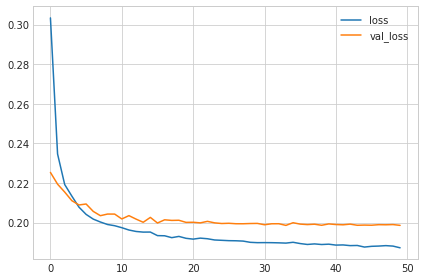

In [6]:
# Define objective (=loss) and training (=optimizer)
model.compile(
    optimizer='adam',
    loss='mae',
)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0,
)

# Plot results
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

From the learning curves, you can see that the validation loss remains near a constant minimum even though the training loss continues to decrease. So we can see that adding dropout did prevent overfitting this time. Moreover, by making it harder for the network to fit spurious patterns, dropout may have encouraged the network to seek out more of the true patterns, possibly improving the validation loss some as well).

# Preparation (Batch Normalization)

In [7]:
# Import data
concrete = pd.read_csv('../input/dl-course-data/concrete.csv')
df = concrete.copy()

In [8]:
# Split into training and validation data
df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

X_train = df_train.drop('CompressiveStrength', axis=1)
X_valid = df_valid.drop('CompressiveStrength', axis=1)
y_train = df_train['CompressiveStrength']
y_valid = df_valid['CompressiveStrength']

input_shape = [X_train.shape[1]]

# Build Batch Normalization Model

Minimum Validation Loss: nan


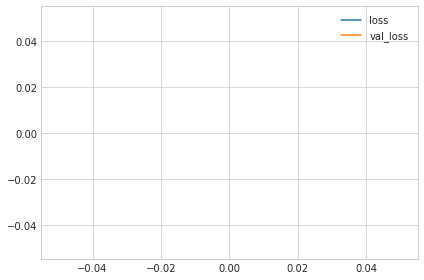

In [9]:
# Define model without batch normalization
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.Dense(512, activation='relu'),    
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])

# Define objective (=loss) and training (=optimizer)
model.compile(
    optimizer='sgd', # SGD is more sensitive to differences of scale
    loss='mae',
    metrics=['mae'],
)

# Train model on unstandardized data
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=100,
    verbose=0,
)

# Plot results
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

Did you end up with a blank graph? Trying to train this network on this dataset will usually fail. Even when it does converge (due to a lucky weight initialization), it tends to converge to a very large number.

Minimum Validation Loss: 4.1167


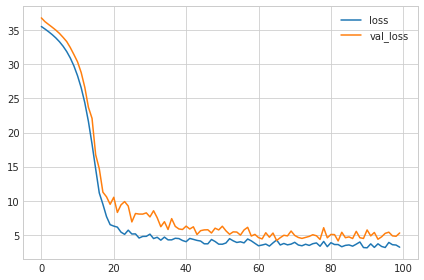

In [10]:
# Define model with batch normalization layer before each dense layer
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(units=512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(units=512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(units=512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1),
])

# Define objective (=loss) and training (=optimizer)
model.compile(
    optimizer='sgd',
    loss='mae',
    metrics=['mae'],
)

# Train model on normalized data
EPOCHS = 100
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=EPOCHS,
    verbose=0,
)

# Plot results
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

You can see that adding batch normalization was a big improvement on the first attempt! By adaptively scaling the data as it passes through the network, batch normalization can let you train models on difficult datasets.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/intro-to-deep-learning/discussion) to chat with other learners.*